(GP-TProcess)=
# Student-t Process

:::{post} August 2017
:tags: t-process, gaussian process, nonparametric
:category: intermediate
:author: Bill Engels
:::

PyMC also includes T-process priors.  They are a generalization of a Gaussian process prior to the multivariate Student's T distribution.  The usage is identical to that of `gp.Latent`, except they require a degrees of freedom parameter when they are specified in the model.  For more information, see chapter 9 of [Rasmussen+Williams](http://www.gaussianprocess.org/gpml/), and [Shah et al.](https://arxiv.org/abs/1402.4306).

Note that T processes aren't additive in the same way as GPs, so addition of `TP` objects are not supported.

## Samples from a TP prior

The following code draws samples from a T process prior with 3 degrees of freedom and a Gaussian process, both with the same covariance matrix.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt

from pymc.gp.util import plot_gp_dist

%matplotlib inline

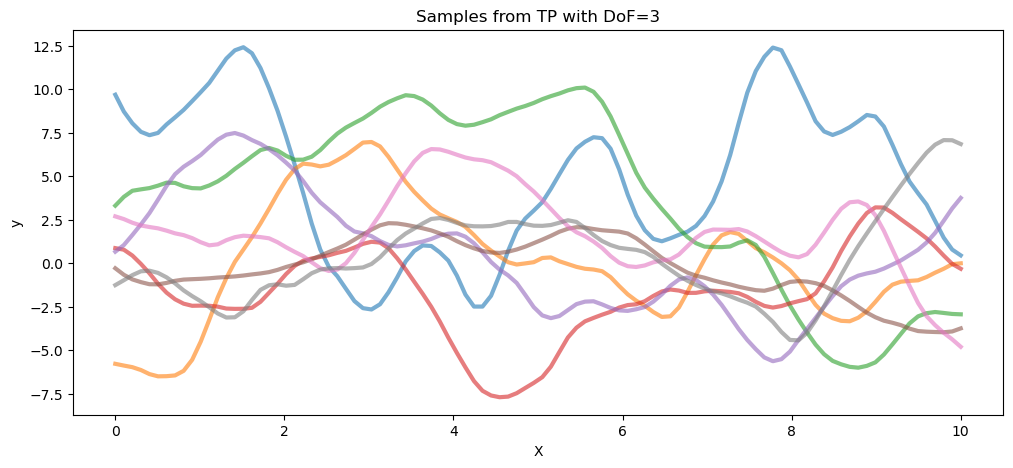

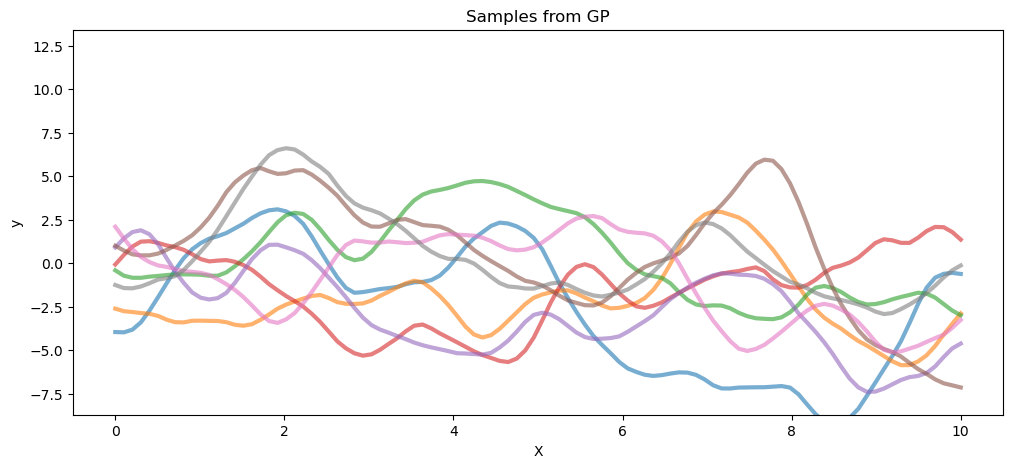

In [2]:
# set the seed
np.random.seed(1)

n = 100  # The number of data points
X = np.linspace(0, 10, n)[:, None]  # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
ell_true = 1.0
eta_true = 3.0
cov_func = eta_true**2 * pm.gp.cov.Matern52(1, ell_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
tp_samples = pm.draw(pm.MvStudentT.dist(mu=mean_func(X).eval(), scale=cov_func(X).eval(), nu=3), 8)

## Plot samples from TP prior
fig = plt.figure(figsize=(12, 5))
ax0 = fig.gca()
ax0.plot(X.flatten(), tp_samples.T, lw=3, alpha=0.6)
ax0.set_xlabel("X")
ax0.set_ylabel("y")
ax0.set_title("Samples from TP with DoF=3")


gp_samples = pm.draw(pm.MvNormal.dist(mu=mean_func(X).eval(), cov=cov_func(X).eval()), 8)
fig = plt.figure(figsize=(12, 5))
ax1 = fig.gca()
ax1.plot(X.flatten(), gp_samples.T, lw=3, alpha=0.6)
ax1.set_xlabel("X")
ax1.set_ylabel("y")
ax1.set_ylim(ax0.get_ylim())
ax1.set_title("Samples from GP");

## Poisson data generated by a T process

For the Poisson rate, we take the square of the function represented by the T process prior.

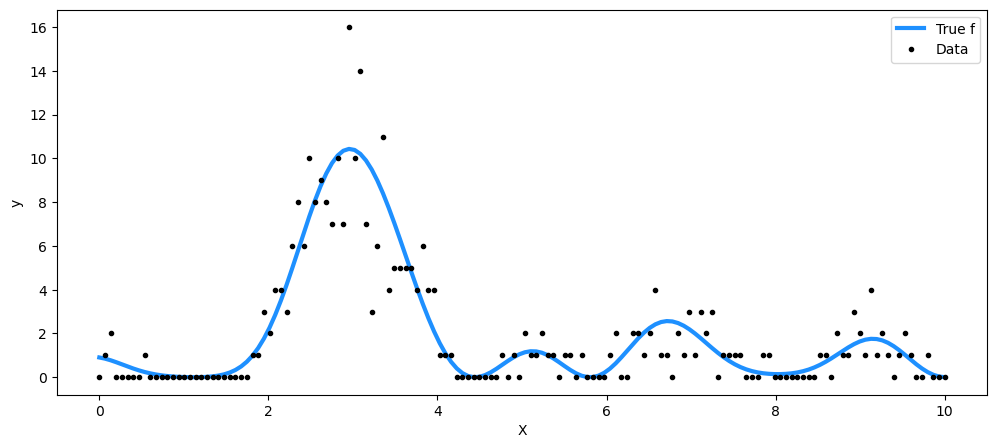

In [3]:
np.random.seed(7)

n = 150  # The number of data points
X = np.linspace(0, 10, n)[:, None]  # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
ell_true = 1.0
eta_true = 3.0
cov_func = eta_true**2 * pm.gp.cov.ExpQuad(1, ell_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = pm.draw(pm.MvStudentT.dist(mu=mean_func(X).eval(), scale=cov_func(X).eval(), nu=3), 1)
y = np.random.poisson(f_true**2)

fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
ax.plot(X, f_true**2, "dodgerblue", lw=3, label="True f")
ax.plot(X, y, "ok", ms=3, label="Data")
ax.set_xlabel("X")
ax.set_ylabel("y")
plt.legend();

In [4]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=2)
    eta = pm.HalfCauchy("eta", beta=3)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ell)

    # informative prior on degrees of freedom < 5
    nu = pm.Gamma("nu", alpha=2, beta=1)
    tp = pm.gp.TP(scale_func=cov, nu=nu)
    f = tp.prior("f", X=X)

    pm.Poisson("y", mu=pt.square(f), observed=y)

    tr = pm.sample(target_accept=0.9, nuts_sampler="nutpie", chains=2)

/var/home/fonnesbeck/repos/pymc-examples/.pixi/envs/default/lib/python3.12/site-packages/pytensor/graph/rewriting/basic.py:121: UserWarning: A Supervisor feature is missing from FunctionGraph(AdvancedSetSubtensor(Alloc(0.0, *2 -> Shape_i{0}(*0-<Vector(float64, shape=(?,))>), *2), *0-<Vector(float64, shape=(?,))>, *1 -> ARange{dtype='int64'}(0, *2, 1), *1)).
  return self.apply(fgraph, *args, **kwargs)
/var/home/fonnesbeck/repos/pymc-examples/.pixi/envs/default/lib/python3.12/site-packages/pytensor/link/numba/dispatch/basic.py:377: UserWarning: Numba will use object mode to run AdvancedSetSubtensor's perform method
  warnings.warn(
/var/home/fonnesbeck/repos/pymc-examples/.pixi/envs/default/lib/python3.12/site-packages/pytensor/graph/rewriting/basic.py:121: UserWarning: A Supervisor feature is missing from FunctionGraph(AdvancedSetSubtensor(Alloc(0.0, *1 -> Shape_i{0}(*0-<Vector(float64, shape=(?,))>), *1), *0-<Vector(float64, shape=(?,))>, *2 -> ARange{dtype='int64'}(0, *1, 1), *2)).
 

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,21,0.07,127
,2000,13,0.08,127


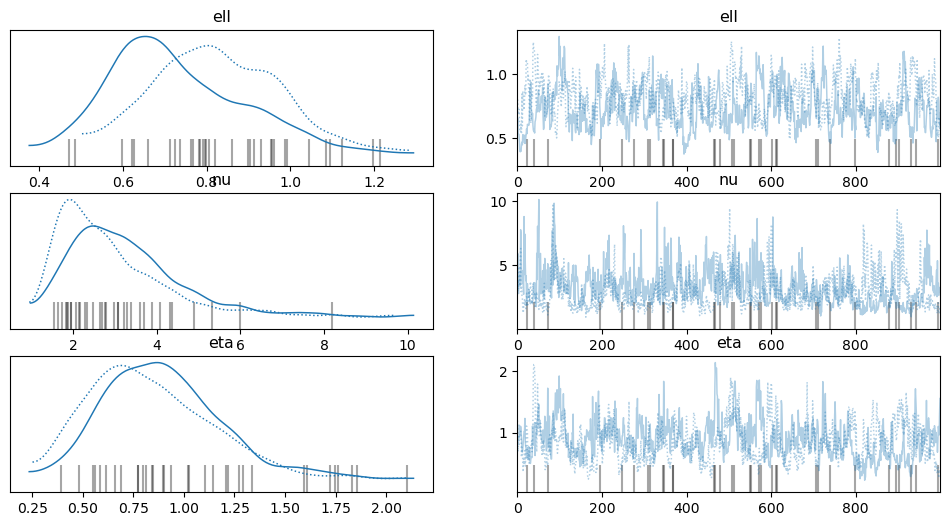

In [5]:
az.plot_trace(tr, var_names=["ell", "nu", "eta"]);

In [6]:
n_new = 200
X_new = np.linspace(0, 15, n_new)[:, None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred = tp.conditional("f_pred", X_new)

# Sample from the GP conditional distribution
with model:
    pm.sample_posterior_predictive(tr, var_names=["f_pred"], extend_inferencedata=True)

Sampling: [f_pred]


Output()

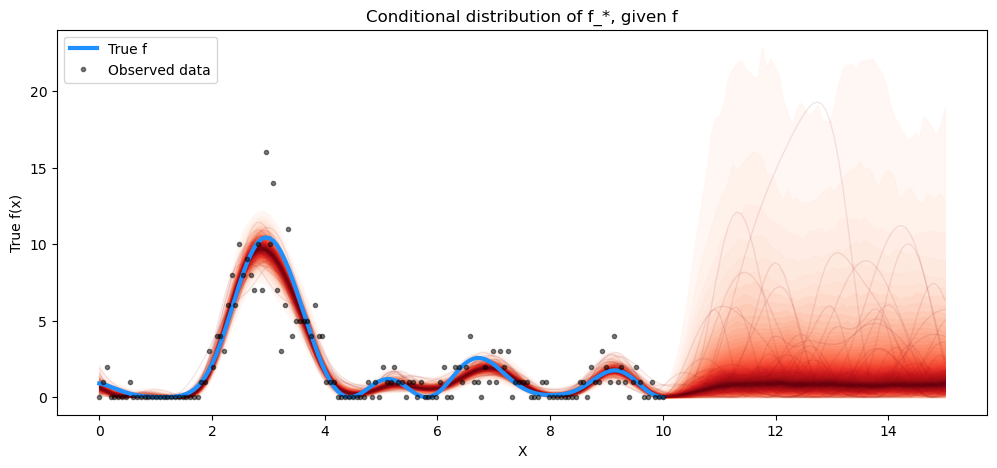

In [7]:
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

f_pred_samples = np.square(
    az.extract(tr.posterior_predictive).astype(np.float32)["f_pred"].values
).T
plot_gp_dist(ax, f_pred_samples, X_new)
plt.plot(X, np.square(f_true), "dodgerblue", lw=3, label="True f")
plt.plot(X, y, "ok", ms=3, alpha=0.5, label="Observed data")
plt.xlabel("X")
plt.ylabel("True f(x)")
plt.title("Conditional distribution of f_*, given f")
plt.legend();

## Authors

* Authored by Bill Engels
* Updated by Chris Fonnesbeck to use PyMC v5

## References
:::{bibliography}
:filter: docname in docnames
:::

In [8]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Sep 20 2024

Python implementation: CPython
Python version       : 3.12.5
IPython version      : 8.27.0

matplotlib: 3.9.2
arviz     : 0.19.0
numpy     : 1.26.4
pymc      : 5.16.2
pytensor  : 2.25.4

Watermark: 2.4.3

